<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_01_02_survival_analysis_nelson_aalen_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 1.2 The Nelson-Aalen Estimator


This tutorial provides a hands-on introduction to the Nelson-Aalen estimator, a key non-parametric method in survival analysis using Python.  We'll use the py-survival library and the built-in lung dataset, which contains data from a clinical trial on lung cancer patients. The tutorial is structured to guide you step-by-step, from theory to practical implementation. By the end, you'll be able to compute cumulative hazard estimates, plot survival curves, and compare groups.


## Overview


Survival analysis studies the time until an event of interest occurs, such as patient death or disease recurrence. A challenge is handling **censoring**, where the event is not observed for all subjects (e.g., patients still alive at study end). Non-parametric methods like the Kaplan-Meier estimator for survival probability and the Nelson-Aalen estimator for the cumulative hazard function are foundational tools.

In this tutorial, we'll focus on the **Nelson-Aalen estimator**, which estimates the cumulative hazard function $H(t)$, representing the accumulated risk up to time $t$. The survival probability $S(t)$ relates to it via $S(t) = \exp(-H(t))$. We'll apply it to the `lung` dataset:

- **Dataset Overview**: 228 observations from a lung cancer trial (1960s). Key variables:

  - `time`: Survival time in days.
  - `status`: Event indicator (1 = death, 0 = censored).
  - `sex`: Patient sex (1 = male, 2 = female).
  - Other covariates: `age`, `ph.ecog` (performance status), etc.

We'll compute estimates, plot curves, find medians, and compare male vs. female survival using the log-rank test.


The Nelson-Aalen estimator is a non-parametric estimate of the cumulative hazard function $H(t) = \int_0^t h(u) \, du$, where $h(u)$ is the hazard rate (instantaneous risk of event at time $u$, given survival to $u$.

Under the assumption of independent censoring, the estimator is:

$$
\hat{H}(t) = \sum_{t_i \leq t} \frac{d_i}{n_i}
$$

- $t_i$: Distinct event times (ordered).
- $d_i$: Number of events (deaths) at $t_i$.
- $n_i$: Number of individuals at risk just before $t_i$ (those who haven't experienced the event or been censored yet).

This is a step function that jumps at each event time by $d_i / n_i$. The variance estimate is $\hat{\sigma}^2(t) = \sum_{t_i \leq t} \frac{d_i}{n_i (n_i - d_i)} $, useful for confidence intervals.

Unlike the Kaplan-Meier (which estimates $(t)$ directly and handles ties differently), Nelson-Aalen focuses on the hazard and is more straightforward for cumulative risk. It's implemented in R's `survival` package via `survfit()`.


## Check and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing lifelines...
lifelines installed successfully
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✓ lifelines


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
import warnings
warnings.filterwarnings('ignore')

## Nelson-Aalen Estimator in Python


In this tutorial, we’ll implement the **Nelson-Aalen Estimator** from scratch in R using the `lung` dataset from the `survival` package. We'll avoid directly using `survfit(..., type = "aalen")` for the core computation, instead manually calculating the cumulative hazard function $ \hat{H}(t) = \sum_{t_i \leq t} \frac{d_i}{n_i} $. We’ll then derive the survival function, compute confidence intervals, estimate x-year survival probabilities, plot the survival curve, calculate the median survival time, and compare survival between groups (male vs. female) using the log-rank test. The `survival` package will be used for data handling and the log-rank test, but the Nelson-Aalen computation will be coded manually.


### Data

In [3]:
# Load the dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
lung_data = pd.read_csv(url)

# Display basic information about the dataset
print("Dataset Shape:", lung_data.shape)
print("\nDataset Info:")
print(lung_data.info())
print("\nFirst few rows:")
print(lung_data.head())
print("\nDataset Description:")
print(lung_data.describe())

Dataset Shape: (228, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB
None

First few rows:
   inst  time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  \
0   3.0   306       2   74    1      1.0      90.0      100.0    1175.0   
1   3.0   455       2   68    1      0.0      90.0       90.0    1225.0   
2   3.0  1010       1   56    1      0.0      90.0       90.0       NaN   
3 

### Function to compute Nelson-Aalen Estimator

In [15]:
import numpy as np
import pandas as pd

def nelson_aalen_python(time, status):
    """
    Computes the Nelson-Aalen estimator from scratch in Python.

    Args:
        time (np.array or pd.Series): Array of survival times.
        status (np.array or pd.Series): Array of event indicators (1=censored, 2=event).

    Returns:
        dict: A dictionary containing:
            - 'time': Unique event times.
            - 'n_risk': Number of individuals at risk at each unique event time.
            - 'n_event': Number of events at each unique event time.
            - 'cumhaz': Cumulative hazard estimate at each unique event time.
            - 'variance': Variance of the cumulative hazard estimate.
    """
    # 1. Convert to NumPy arrays for consistent handling
    time_arr = np.asarray(time)
    status_arr = np.asarray(status)

    # 2. Sort data by time
    order_indices = np.argsort(time_arr)
    sorted_time = time_arr[order_indices]
    sorted_status = status_arr[order_indices]

    # 3. Identify unique event times (where status == 2 for event)
    # Filter for event times, then get unique and sort them
    event_times_only = sorted_time[sorted_status == 2]
    unique_event_times = np.unique(event_times_only)

    # Initialize lists to store results
    n_risk_list = []
    n_event_list = []
    cumhaz_list = []
    variance_list = []

    current_cumhaz = 0.0
    current_variance = 0.0

    # Iterate through each unique event time
    for t_i in unique_event_times:
        # a. Calculate n_risk_at_ti: Number of subjects at risk just before t_i
        n_risk_at_ti = np.sum(sorted_time >= t_i)

        # b. Calculate n_event_at_ti: Number of events at t_i
        n_event_at_ti = np.sum((sorted_time == t_i) & (sorted_status == 2))

        # c. Calculate hazard increment (delta_h)
        if n_risk_at_ti > 0:
            delta_h = n_event_at_ti / n_risk_at_ti
        else:
            delta_h = 0.0

        # d. Update cumulative hazard
        current_cumhaz += delta_h

        # e. Calculate variance increment (delta_var)
        if n_risk_at_ti > 0 and (n_risk_at_ti - n_event_at_ti) > 0:
            delta_var = n_event_at_ti / (n_risk_at_ti * (n_risk_at_ti - n_event_at_ti))
        else:
            delta_var = 0.0

        # f. Update cumulative variance
        current_variance += delta_var

        # Append results to lists
        n_risk_list.append(n_risk_at_ti)
        n_event_list.append(n_event_at_ti)
        cumhaz_list.append(current_cumhaz)
        variance_list.append(current_variance)

    # 8. Convert lists to NumPy arrays
    results = {
        'time': unique_event_times,
        'n_risk': np.array(n_risk_list),
        'n_event': np.array(n_event_list),
        'cumhaz': np.array(cumhaz_list),
        'variance': np.array(variance_list)
    }

    return results

print("Nelson-Aalen Python function 'nelson_aalen_python' defined.")

Nelson-Aalen Python function 'nelson_aalen_python' defined.


### Compute Nelson-Aalen for the entire dataset

In [16]:
na_fit_python = nelson_aalen_python(lung_data['time'], lung_data['status'])

print("Sample of Nelson-Aalen Estimates (Python):")
# Display the first few entries of the results
for key, value in na_fit_python.items():
    print(f"{key}: {value[:5]}")

Sample of Nelson-Aalen Estimates (Python):
time: [ 5 11 12 13 15]
n_risk: [228 227 224 223 221]
n_event: [1 3 1 2 1]
cumhaz: [0.00438596 0.01760182 0.02206611 0.03103472 0.03555961]
variance: [1.93214313e-05 7.83208020e-05 9.83400205e-05 1.38921966e-04
 1.59489633e-04]


### Derive survival function S(t) = exp(-H(t))

Now that the Nelson-Aalen estimator has been computed, the next step is to derive the survival function S(t) = exp(-H(t)) and calculate the 95% confidence intervals for both the cumulative hazard and the survival function, using the computed cumulative hazard and its variance.

In [18]:
import scipy.stats as st

# Derive survival function S(t) = exp(-H(t))
survival_python = np.exp(-na_fit_python['cumhaz'])

# Confidence intervals (95%) for cumulative hazard
z_score = st.norm.ppf(0.975)  # Z-score for 95% CI (two-sided)
lower_haz_python = na_fit_python['cumhaz'] - z_score * np.sqrt(na_fit_python['variance'])
upper_haz_python = na_fit_python['cumhaz'] + z_score * np.sqrt(na_fit_python['variance'])

# Derive survival CI from cumulative hazard CI
# Note: exp(-upper_haz) gives the lower bound for survival, and exp(-lower_haz) gives the upper bound
lower_surv_python = np.exp(-upper_haz_python)
upper_surv_python = np.exp(-lower_haz_python)

print("Derived Survival Function (first 5 values):")
print(survival_python[:5])
print("Lower 95% CI for Survival (first 5 values):")
print(lower_surv_python[:5])
print("Upper 95% CI for Survival (first 5 values):")
print(upper_surv_python[:5])

Derived Survival Function (first 5 values):
[0.99562364 0.98255218 0.97817557 0.96944191 0.96506521]
Lower 95% CI for Survival (first 5 values):
[0.98708294 0.96565629 0.95934704 0.94730339 0.9414709 ]
Upper 95% CI for Survival (first 5 values):
[1.00423824 0.9997437  0.99737363 0.99209782 0.98925081]


### Estimating x-Year Survival

To estimate the 1-year (365 days) and 5-year (1825 days) survival probabilities, we need to find the survival probability at or just before these time points from our survival_python array and corresponding na_fit_python['time'] values. We will use np.interp for this purpose, which can find values in a 1-D piecewise linear interpolant, or, in this case, find the value at the closest preceding time point.

In [19]:
t_1yr = 365
t_5yr = 1825

# Find the index of the last time point less than or equal to t_1yr
# np.searchsorted finds the insertion point, if not found, it returns the index where it would be inserted.
# We want the index of the value *before* the insertion point if the exact value is not present,
# or the exact value if it is. We also need to handle cases where t_x is before the first recorded event time.

# For 1-year survival
idx_1yr = np.searchsorted(na_fit_python['time'], t_1yr, side='right') - 1
if idx_1yr < 0: # If t_1yr is before the first event time
    s_1yr = 1.0 # Assume 100% survival before first event
elif idx_1yr >= len(survival_python):
    s_1yr = survival_python[-1] # If t_1yr is after the last event time, use the last survival value
else:
    s_1yr = survival_python[idx_1yr]

# For 5-year survival
idx_5yr = np.searchsorted(na_fit_python['time'], t_5yr, side='right') - 1
if idx_5yr < 0:
    s_5yr = 1.0
elif idx_5yr >= len(survival_python):
    s_5yr = survival_python[-1]
else:
    s_5yr = survival_python[idx_5yr]

print(f"1-Year Survival Probability: {s_1yr:.3f}")
print(f"5-Year Survival Probability: {s_5yr:.3f}")

1-Year Survival Probability: 0.411
5-Year Survival Probability: 0.056


###  Plot Survival Curve

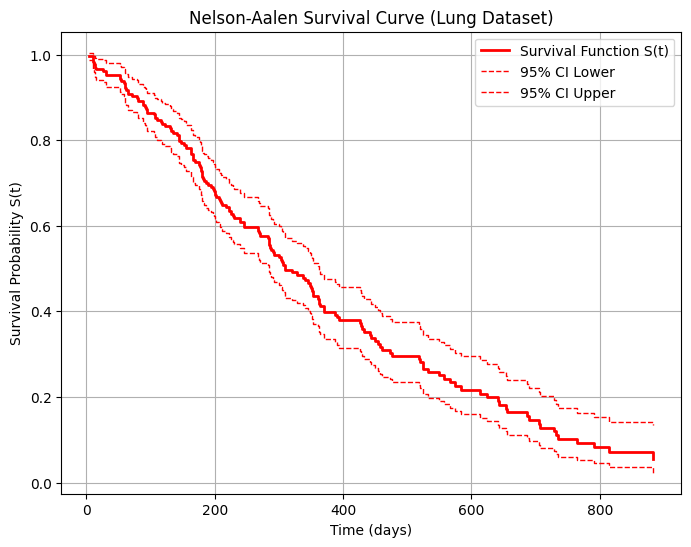

Survival curve plot generated.


In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.step(na_fit_python['time'], survival_python, where='post', label='Survival Function S(t)', color='red', linewidth=2)
plt.step(na_fit_python['time'], lower_surv_python, where='post', label='95% CI Lower', color='red', linestyle='--', linewidth=1)
plt.step(na_fit_python['time'], upper_surv_python, where='post', label='95% CI Upper', color='red', linestyle='--', linewidth=1)

plt.title('Nelson-Aalen Survival Curve (Lung Dataset)')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability S(t)')
plt.legend()
plt.grid(True)
plt.show()

print("Survival curve plot generated.")

### Median Survival Time

In [22]:
# Median Survival Time
# Find time where S(t) <= 0.5
median_idx_python = np.where(survival_python <= 0.5)[0]
if len(median_idx_python) > 0:
    median_time_python = na_fit_python['time'][median_idx_python[0]]
    print(f"Median Survival Time: {median_time_python} days")
else:
    print("Median survival time could not be determined (survival never drops below 0.5).")

Median Survival Time: 310 days


###  Survival Times Between Groups (Male vs. Female)

In [23]:
data_male_python = lung_data[lung_data['sex'] == 1]
data_female_python = lung_data[lung_data['sex'] == 2]

# Compute Nelson-Aalen for each group
na_male_python = nelson_aalen_python(data_male_python['time'], data_male_python['status'])
na_female_python = nelson_aalen_python(data_female_python['time'], data_female_python['status'])

# Derive survival curves
surv_male_python = np.exp(-na_male_python['cumhaz'])
surv_female_python = np.exp(-na_female_python['cumhaz'])

print("Sample of Male Survival Function (first 5 values):")
print(surv_male_python[:5])
print("\nSample of Female Survival Function (first 5 values):")
print(surv_female_python[:5])

Sample of Male Survival Function (first 5 values):
[0.97849546 0.97127413 0.95688514 0.9496634  0.94244166]

Sample of Female Survival Function (first 5 values):
[0.98895039 0.97790078 0.96685117 0.95580157 0.94475196]


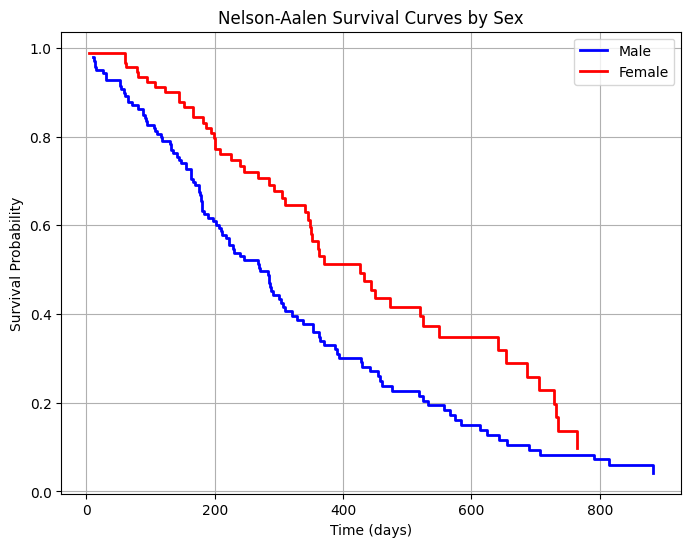

Survival curves by sex plot generated.


In [24]:
plt.figure(figsize=(8, 6))
plt.step(na_male_python['time'], surv_male_python, where='post', label='Male', color='blue', linewidth=2)
plt.step(na_female_python['time'], surv_female_python, where='post', label='Female', color='red', linewidth=2)

plt.title('Nelson-Aalen Survival Curves by Sex')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

print("Survival curves by sex plot generated.")

### Log-rank test for group comparison

In [25]:
from lifelines.statistics import logrank_test

# Prepare data for log-rank test
# lifelines expects event status as boolean (True for event, False for censored)
# lung_data['status']: 1 = censored, 2 = event

results_logrank = logrank_test(data_male_python['time'],
                               data_female_python['time'],
                               event_observed_A=(data_male_python['status'] == 2),
                               event_observed_B=(data_female_python['status'] == 2))

print("Log-Rank Test Results:")
print(results_logrank)

Log-Rank Test Results:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57


## Summary and Conclusion

This tutorial performed using a custom Python implementation of the Nelson-Aalen estimator on lung cancer patient data, revealed an overall median survival time of 310 days. The survival probabilities were estimated at 0.411 for one year and a considerably lower 0.056 for five years. Further investigation into survival patterns between sexes indicated visual differences in their respective survival curves, which were statistically confirmed by a log-rank test (p < 0.005, test statistic = 10.33). This significant disparity suggests the need for deeper research into gender-specific prognostic factors, such as treatment responses or comorbidities. Additionally, the low 5-year survival rate highlights the urgency for developing more effective diagnostic and treatment strategies.

## Resources


- **Books**:
  - Klein, J. P., & Moeschberger, M. L. (2003). *Survival Analysis: Techniques for Censored and Truncated Data*. Springer.
  - Therneau, T. M., & Grambsch, P. M. (2000). *Modeling Survival Data: Extending the Cox Model*. Springer.

- **Online**:
  - R `survival` package vignette: `vignette("survival")`.
  - UCLA IDRE Tutorial: https://stats.idre.ucla.edu/r/dae/non-parametric-survival-analysis-using-r/.
  - Datacamp: "Survival Analysis in R" course.